In [ ]:
!pip install torchvision --user
!pip install opencv-python --user
!pip install pycocotools --user
!pip install roboflow --user

In [26]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torchvision.ops import box_iou
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A  # our data augmentation library

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

from albumentations.pytorch import ToTensorV2

import sys

In [27]:
print(torch.__version__)
print(torchvision.__version__)

1.11.0+cu115
0.12.0+cu115


In [28]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
          #  A.Resize(600, 600), # our input size can be 600px
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

In [29]:
class LicensePlateDataset(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        # the 3 transform parameters are reuqired for datasets.VisionDataset
        super().__init__(root, transforms, transform, target_transform)
        self.split = split #train, valid, test
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json")) # annotatiosn stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]

    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))

    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))

        boxes = [t['bbox'] + [t['category_id']] for t in target] # required annotation format for albumentations
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)

        image = transformed['image']
        boxes = transformed['bboxes']

        new_boxes = [] # convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.tensor(new_boxes, dtype=torch.float32)

        targ = {} # here is our transformed target
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ # scale images
    def __len__(self):
        return len(self.ids)

In [30]:
from roboflow import Roboflow
rf = Roboflow(api_key="uxxkyeauysIZUWSComQv")
project = rf.workspace("plat-nomor-indonesia").project("plat-nomor-indonesia-hdxeg")
version = project.version(3)
dataset = version.download("coco")
                

loading Roboflow workspace...
loading Roboflow project...


In [31]:
dataset_path = 'Plat-Nomor-Indonesia-3'

In [32]:
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


{0: {'id': 0, 'name': 'platMobil', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'license-plate', 'supercategory': 'platMobil'}}

In [33]:
classes = [i[1]['name'] for i in categories.items()]
classes

['platMobil', 'license-plate']

In [34]:
train_dataset = LicensePlateDataset(root=dataset_path, transforms=get_transforms(True))

loading annotations into memory...
Done (t=0.14s)
creating index...
index created!


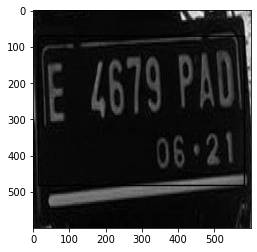

In [35]:
# Lets view a sample
sample = train_dataset[457]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
).permute(1, 2, 0))

In [36]:
len(train_dataset)

2972

In [37]:
# lets load the faster rcnn model
model = models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

In [38]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [39]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)

In [40]:
images,targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets) # just make sure this runs without error

In [41]:
device = torch.device("cuda") # use GPU to train

In [42]:
model = model.to(device)

In [43]:
# Now, and optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)
# lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[16, 22], gamma=0.1) # lr scheduler

In [44]:
 def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()

#     lr_scheduler = None
#     if epoch == 0:
#         warmup_factor = 1.0 / 1000 # do lr warmup
#         warmup_iters = min(1000, len(loader) - 1)

#         lr_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor = warmup_factor, total_iters=warmup_iters)

    all_losses = []
    all_losses_dict = []

    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()

        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping trainig") # train if loss becomes infinity
            print(loss_dict)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

#         if lr_scheduler is not None:
#             lr_scheduler.step() #

    all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))

In [45]:
num_epochs=20

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)
#     lr_scheduler.step()

100%|██████████| 743/743 [03:06<00:00,  3.98it/s]


Epoch 0, lr: 0.010000, loss: 0.907707, loss_classifier: 0.276382, loss_box: 0.618786, loss_rpn_box: 0.002909, loss_object: 0.009629


100%|██████████| 743/743 [03:40<00:00,  3.37it/s]


Epoch 1, lr: 0.010000, loss: 0.891012, loss_classifier: 0.256389, loss_box: 0.625438, loss_rpn_box: 0.002407, loss_object: 0.006777


100%|██████████| 743/743 [03:29<00:00,  3.54it/s]


Epoch 2, lr: 0.010000, loss: 0.884461, loss_classifier: 0.243757, loss_box: 0.632564, loss_rpn_box: 0.002240, loss_object: 0.005899


100%|██████████| 743/743 [03:26<00:00,  3.60it/s]


Epoch 3, lr: 0.010000, loss: 0.864886, loss_classifier: 0.228623, loss_box: 0.628724, loss_rpn_box: 0.002054, loss_object: 0.005485


100%|██████████| 743/743 [03:28<00:00,  3.57it/s]


Epoch 4, lr: 0.010000, loss: 0.852553, loss_classifier: 0.217635, loss_box: 0.627810, loss_rpn_box: 0.001984, loss_object: 0.005125


100%|██████████| 743/743 [03:26<00:00,  3.60it/s]


Epoch 5, lr: 0.010000, loss: 0.841939, loss_classifier: 0.211886, loss_box: 0.623285, loss_rpn_box: 0.001922, loss_object: 0.004846


100%|██████████| 743/743 [03:25<00:00,  3.61it/s]


Epoch 6, lr: 0.010000, loss: 0.825906, loss_classifier: 0.209409, loss_box: 0.609763, loss_rpn_box: 0.001957, loss_object: 0.004777


100%|██████████| 743/743 [03:22<00:00,  3.67it/s]


Epoch 7, lr: 0.010000, loss: 0.809109, loss_classifier: 0.202234, loss_box: 0.600475, loss_rpn_box: 0.001858, loss_object: 0.004542


100%|██████████| 743/743 [03:26<00:00,  3.61it/s]


Epoch 8, lr: 0.010000, loss: 0.821331, loss_classifier: 0.202384, loss_box: 0.612642, loss_rpn_box: 0.001843, loss_object: 0.004462


100%|██████████| 743/743 [03:24<00:00,  3.64it/s]


Epoch 9, lr: 0.010000, loss: 0.773657, loss_classifier: 0.188318, loss_box: 0.579139, loss_rpn_box: 0.001834, loss_object: 0.004366


100%|██████████| 743/743 [01:39<00:00,  7.49it/s]


Epoch 10, lr: 0.010000, loss: 0.815895, loss_classifier: 0.192513, loss_box: 0.617238, loss_rpn_box: 0.001865, loss_object: 0.004279


100%|██████████| 743/743 [00:40<00:00, 18.44it/s]


Epoch 11, lr: 0.010000, loss: 0.773924, loss_classifier: 0.190616, loss_box: 0.577066, loss_rpn_box: 0.001857, loss_object: 0.004385


100%|██████████| 743/743 [00:40<00:00, 18.14it/s]


Epoch 12, lr: 0.010000, loss: 0.795919, loss_classifier: 0.183835, loss_box: 0.606480, loss_rpn_box: 0.001704, loss_object: 0.003899


100%|██████████| 743/743 [00:40<00:00, 18.41it/s]


Epoch 13, lr: 0.010000, loss: 0.751184, loss_classifier: 0.188213, loss_box: 0.556990, loss_rpn_box: 0.001759, loss_object: 0.004222


100%|██████████| 743/743 [00:41<00:00, 18.01it/s]


Epoch 14, lr: 0.010000, loss: 0.774011, loss_classifier: 0.182797, loss_box: 0.585435, loss_rpn_box: 0.001717, loss_object: 0.004062


100%|██████████| 743/743 [00:41<00:00, 17.95it/s]


Epoch 15, lr: 0.010000, loss: 0.724605, loss_classifier: 0.175664, loss_box: 0.543304, loss_rpn_box: 0.001639, loss_object: 0.003997


100%|██████████| 743/743 [00:41<00:00, 17.96it/s]


Epoch 16, lr: 0.010000, loss: 0.733035, loss_classifier: 0.176593, loss_box: 0.550911, loss_rpn_box: 0.001652, loss_object: 0.003878


100%|██████████| 743/743 [00:41<00:00, 17.76it/s]


Epoch 17, lr: 0.010000, loss: 0.725812, loss_classifier: 0.167488, loss_box: 0.552893, loss_rpn_box: 0.001618, loss_object: 0.003813


100%|██████████| 743/743 [00:41<00:00, 17.90it/s]


Epoch 18, lr: 0.010000, loss: 0.686572, loss_classifier: 0.167326, loss_box: 0.513555, loss_rpn_box: 0.001671, loss_object: 0.004020


100%|██████████| 743/743 [00:41<00:00, 17.83it/s]

Epoch 19, lr: 0.010000, loss: 0.723641, loss_classifier: 0.170088, loss_box: 0.548155, loss_rpn_box: 0.001629, loss_object: 0.003768


In [46]:
# we will watch first epoich to ensure no errrors
# while it is training, lets write code to see the models predictions. lets try again
model.eval()
torch.cuda.empty_cache()

In [ ]:
val_dataset = LicensePlateDataset(root=dataset_path, split="valid", transforms=get_transforms(False))

In [22]:
test_dataset = LicensePlateDataset(root=dataset_path, split="test", transforms=get_transforms(False))

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [23]:
img, _ = test_dataset[45]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

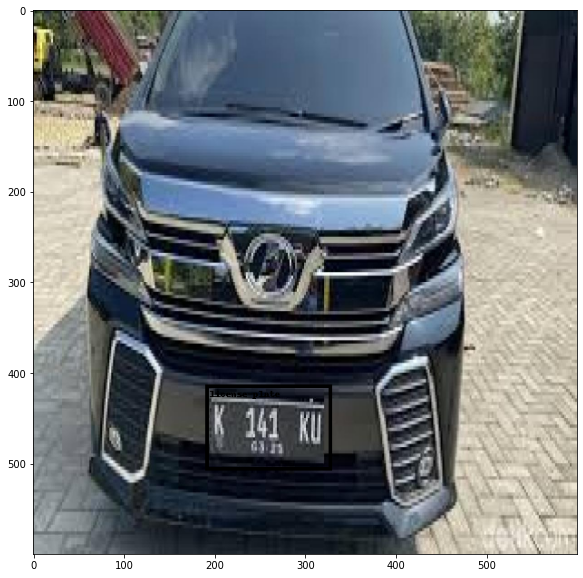

In [24]:
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.8],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
).permute(1, 2, 0))

In [47]:
torch.save(model, 'best2lite.pth')